# ASEN 6519 Fall 2018 - Midterm Project 
## Extended KF and Ensemble Filters with Lorenz-63

### The Lorenz-63 Model
Low-dimensional model: the state is made of 3 variables $x = (x1, x2, x3)$ and dynamical system evolution is given by the following equations:

$$\frac{\partial x_1}{\partial t} = -Ax_1 + Ax_2$$
$$\frac{\partial x_2}{\partial t} = Bx_1 - x_1x_3 - x_2$$
$$\frac{\partial x_3}{\partial t} = x_1x_2 - Cx_3$$

where $A=10$, $B=28$, and $C=8/3$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### 1. Generate $true$ state and synthetic observations using Lorenz63 setup with the default inputs.

In [2]:
def dfdt(r, coeffs):
    '''
    Returns dx1/dt, dx2/dt, dx3/dt
    '''
    # Current position
    #r = np.ravel(r)
    x1 = r[0]
    x2 = r[1]
    x3 = r[2]
    
    # Extract coefficients
    A = coeffs[0]
    B = coeffs[1]
    C = coeffs[2]
    
    # Calculate the derivative
    dx1 = -A*x1 + A*x2
    dx2 = B*x1 - x1*x3 - x2
    dx3 = x1*x2 - C*x3
    
    return np.array([dx1, dx2, dx3], float)

In [3]:
def advance_time(r, coeffs, h):
    '''
    Calculate the state of the system at time t+1 using RK4
    
    Inputs:
        r - the state
        coeffs - the standard Lorenz system coefficients
        h - timstep
    '''
    
    # Calculate Runge-Kutta4 coefficients
    k1 = h*dfdt(r, coeffs)
    k2 = h*dfdt(r+0.5*k1, coeffs)
    k3 = h*dfdt(r+0.5*k2, coeffs)
    k4 = h*dfdt(r+k3, coeffs)
    
    # Update current position
    r += (k1 + 2*k2 + 2*k3 + k4)/6
    
    return r

#### Setup Model

In [4]:
## Model setup  (Do not change)
N_state = 3 # Number of state variables
MO = 3      # Number of measurement variables

A_lor = 10  # Default Lorenz system parameters
B_lor = 28
C_lor = 8/3
coeffs = np.array([A_lor, B_lor, C_lor],float)

# Numerical parameters
t0 = 0          # sec, initial time
tf_assim = 3    # sec, final time   of forecast
tf_fore = 1     # sec, final length of forecast
h_sys = 0.01    # sec, timestep for system dynamics
dyn2meas = 20   # Number of dynamics updates per measurement
h_obs = h_sys * dyn2meas     # sec; an observation is generated every h_obs sec
t_sys = np.arange(t0,tf_assim,h_sys)     # time stamps for system dynamics
t_obs = np.arange(t0,tf_assim,h_obs)     # time stamps for observations
N_sys = len(t_sys)               # Number of system timesteps
N_obs = len(t_obs)               # Number of observations

## Initial conditions
x_true = np.zeros([N_state, N_sys])  # True history of x1 (without any noise)
x_s = np.zeros([N_state, N_sys])     # Noisy history of x1 (with process noise)
y = np.zeros([MO, N_obs])  # Measurements of x1 (with measurement noise)

# default input parameters, she uses 'astr' name
x1_0 = 1.5
x2_0 = -1.5
x3_0 = 25.5

#### Setup Errors/Covariances

In [5]:
## Background error variance
var_b = 1   
B_struct = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]])
B_cov = var_b * B_struct

# Note: dont have usehigh order scheme
# note forget about Q
## Model error covariance (ie: process noise), from Evensen 1997
Q = np.zeros((3,3))
Q[0,0] = 0.1491
Q[0,1] = 0.1505
Q[0,2] = 0.0007
Q[1,0] = 0.1505
Q[1,1] = 0.9048
Q[1,2] = 0.0014
Q[2,0] = 0.0007
Q[2,1] = 0.0014
Q[2,2] = 0.9180
# Qsqrt_cov = np.linalg.cholesky(Q)
L, V = np.linalg.eig(Q)
Qsqrt_cov = V*np.sqrt(L)    # TODO: Why this?

## Misc errors which I do not understand yet but need to run the system
varobs = 3   # Observation error variance
svar = 0.3

## Measurement covariance
sobs = np.sqrt(varobs)
R_struct = np.eye(3)
R = varobs * R_struct
L, V = np.linalg.eig(R)
Msqrt_cov = V*np.sqrt(L)

# ## Generate all the process noise ahead of time
# pnoise_seed = np.random.randn(MO, N_sys)
# pnoise = Qsqrt_cov @ pnoise_seed

#### Run the System: Generate States ($x_{true}$)

In [6]:
## Iterate through time and simulate dynamics
r = np.array([[x1_0, x2_0, x3_0]], float).T   # "Current" position

## Set ICs
x_true[:,0] = np.squeeze(r)

for i in range(1,N_sys):
    # Advance time step (i+1)
    x_true[:,i] = advance_time(x_true[:,i-1], coeffs, h_sys)

#### Generate Measurements

In [7]:
for i in range(N_obs):
    # this reads in states from 0 to 300 in increments of 20 to get even spread of obseravations
    # [:,np.newaxis] makes dimensions from 3, to 3x1.
    curr_state = x_true[:,i*dyn2meas][:,np.newaxis]
    # for each state selected, obs = Measurement covariance + randomness
    y[:,i] = np.squeeze(curr_state + Msqrt_cov @ np.random.randn(3,1))

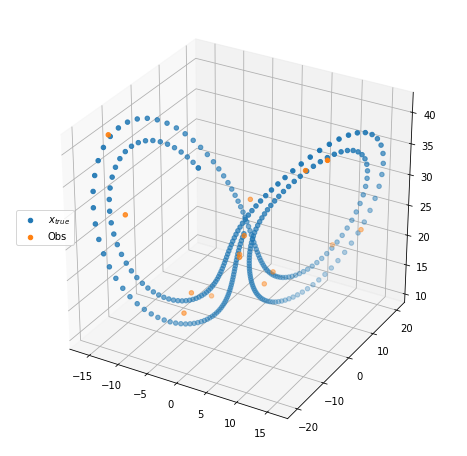

In [8]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_true[0,:],x_true[1,:],x_true[2,:],label='$x_{true}$')
#ax.scatter(x_s[0,:],x_s[1,:],x_s[2,:],label='$x_{noisy}$')#,s=100,marker='x')
ax.scatter(y[0,:],y[1,:],y[2,:],label='Obs')#,s=100,marker='x')
ax.legend(loc=6)
plt.show()

### 2. Implement your own EKF to estimate $x_a$. 
The tangent linear and adjoint codes are provided.
 - Investigate the performance of filter in terms of the bias and mean-square-error of data assimilation analysis. How does the estimate-error computed from $x_a$ and the truth value of $x$ compare to the error variance suggested by the posterior covariance?
 - Examine the sensitivity of the filter performance to the errors in the background. (Compare at least 10 cases)
 - Examine the sensitivity of the filter performance to the accuracy and frequency of observations. Is it better to have frequent but inaccurate observations or infrequent but accurate ones? (Compare at least $10\times 10$ cases.)

# Here's the full loop

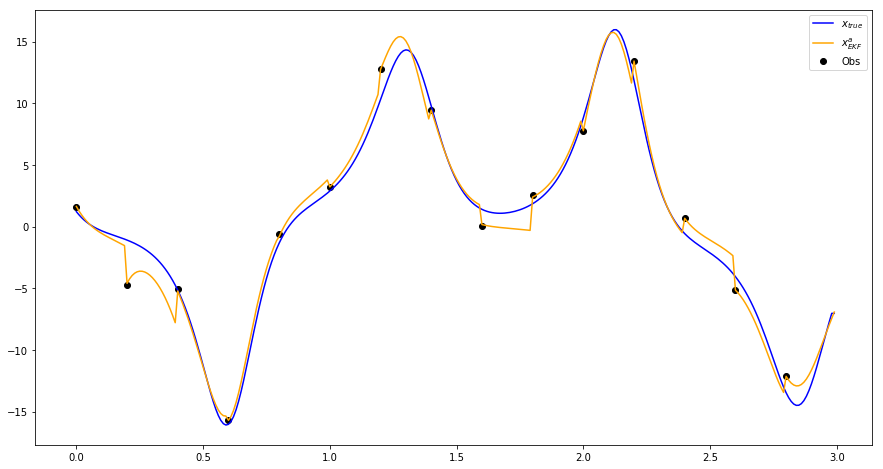

In [71]:
## Set up necessary matrixies
A,B,C = coeffs
H = np.eye(3)
I = np.eye(3)
y_mat = np.matrix(y)

## Store histories
xf_EKF = np.matrix(np.zeros([3, N_sys]))
Pf_EKF = np.zeros(shape=[3,3,N_sys])
xa_EKF = np.matrix(np.zeros([3, N_sys]))
Pa_EKF = np.zeros(shape=[3,3,N_sys])

xf_EKF[:,0] = y_mat[:,0]
Pf_EKF[:,:,0] = Pa
xa_EKF[:,0] = y_mat[:,0]
Pa_EKF[:,:,0] = Pa

## ICs for the EKF
xa = np.array([[y[0,0], y[1,0], y[2,0]]], float).T
Pa = B_cov


obs_increments = np.arange(t0,N_sys,dyn2meas)
obs_time = -1

for i in range(0,N_sys):
        
    xa = np.array(xa, float)
    
    if i not in obs_increments:
       
        # Which one Evensen?
        #xf = xa # ((((This or line below)))) # Evensen Ch4 says if no measurement, xa = xf
        xf = advance_time(xa, coeffs, h_sys) # Forecast mean

        xa = xf
        Pf = Pa

        xf_EKF[:,i], Pf_EKF[:,:,i] = xf, Pf  # Store forecast
        xa_EKF[:,i], Pa_EKF[:,:,i] = xa, Pa  # Store forecast

    if i in obs_increments:
        # Tangent Linear Model (M)
        obs_time += 1
        Y = y_mat[:,obs_time]
        
        x1, x2, x3 = xa[0,0], xa[1,0], xa[2,0] #x1,x2,x3 = np.ravel(xa)  
        M = np.matrix([
            [-A  ,  A  ,  0.0],
            [B-x3, -1.0,  -x1],
            [x2  , x1  ,  -C]])
    
        #Forecast Step:
        # basically xf = M(xa) ==> advance_time(xa)
        xf = advance_time(xa, coeffs, h_sys)
        Pf = M @ Pa @ M.T + Q # remove Q?
    
        #Update Step:
        K = Pf @ H.T @ np.matrix(R + H @ Pf @ H.T).I
        xa = xf + K @ ( Y - H @ xf) # 2x1
        Pa = (I - K @ H) @ Pf # 2x2
    
        # storage of data.
        xf_EKF[:,i], Pf_EKF[:,:,i] = xf, Pf  # Store forecast
        xa_EKF[:,i], Pa_EKF[:,:,i] = np.matrix(xa), Pa  # Store forecast
        

## Plot true state; state evolved with process noise; true state + measurement noise
plt.figure(figsize=[15,8])

plt.plot(t_sys, x_true[0,:],color='blue',label='$x_{true}$')
plt.scatter(t_obs, y[0,:],color='black',label='Obs')
plt.plot(t_sys, np.ravel(xa_EKF[0,:]),color='orange',label='$x^a_{EKF}$')
plt.legend();plt.show()

# There the original old way

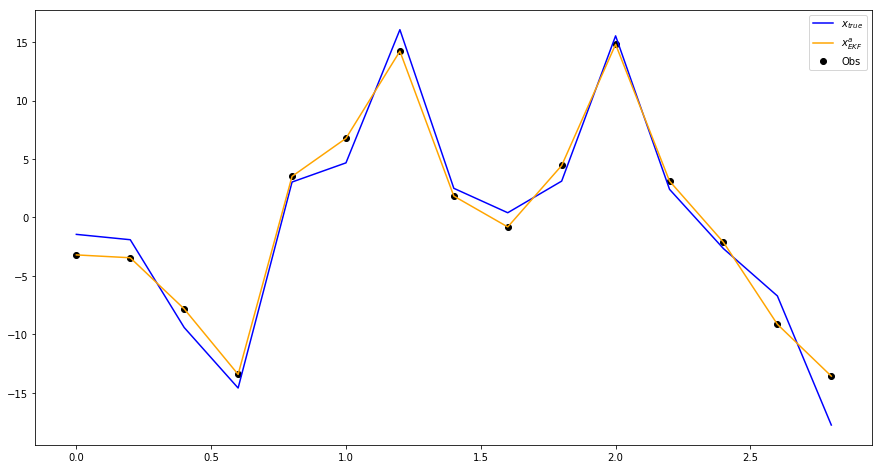

In [133]:
# keep constant
A,B,C = coeffs

# initial state (by obs)
xa = np.array([[y[0,0], y[1,0], y[2,0]]], float).T

# initial Background-covariance
Pa = B_cov.copy()

# R-value?
Msqrt_cov = V*np.sqrt(L)
R = Msqrt_cov.copy()

# Q-value (not Q-matrix made above)
Q = Qsqrt_cov.copy() * 50.

# H is linear here
H = np.eye(3)
I = np.eye(3)


y_mat = np.matrix(y)
xa_EKF = np.matrix(np.zeros([3, 15]))
Pa_EKF = np.zeros(shape=[3,3,15])
obs_times = np.arange(0,N_sys,20)

for i in range(N_obs):

    # Tangent Linear Model (M)
    x1,x2,x3 = np.ravel(xa)   
    M = np.matrix([
        [-A  ,  A  ,  0.0],
        [B-x3, -1.0,  -x1],
        [x2  , x1  ,  -C]])
    
    #Forecast Step:
    xa = np.array([[x1,x2,x3]], float).T
    # basically xf = M(xa) ==> advance_time(xa)
    xf = advance_time(xa, coeffs, h_obs) # try 15 instead of h_obs, 0.02? why h_obs?
    Pf = M @ Pa @ M.T + Q*50 # remove Q?
    
    #Update Step:
    K = Pf @ H.T @ np.matrix(R + H @ Pf @ H.T).I
    xa = xf + K @ ( y_mat[:,i] - H @ xf) # 2x1
    Pa = (I - K @ H) @ Pf # 2x2
    
    # storage of data.
    Pa_EKF[:,:,i] = Pa
    xa_EKF[:,i] = np.matrix(xa)
    
## Plot true state; state evolved with process noise; true state + measurement noise
plt.figure(figsize=[15,8])

plt.plot(t_obs, x_true[1,obs_times],color='blue',label='$x_{true}$')
plt.scatter(t_obs, y[1,:],color='black',label='Obs')
plt.plot(t_obs, np.ravel(xa_EKF[1,:]),color='orange',label='$x^a_{EKF}$')
plt.legend();plt.show()

### 3. Implement your own EnKF (with perturb observations) or EnSRF to estimate $x_a$.
 - Initialize the ensemble by introducing small perturbations to the state and integrating the model until its error growth saturates.
 - Compare the performance of the ensemble method to EKF with respect to each sub-question above. Launch ensemble forecasts (instead of deterministic forecasts) at the end of the assimilation period.
 - Evaluate the ensemble by using rank histograms.
 - Examine the impact of increasing or decreasing ensemble size on the filter performance as well as the forecast performance.

In [96]:
'''## Generate initial ensemble
N_ens = 40   # number of ensemble members

# storages EnKF updates per iteration.
xa_EnKF = np.zeros(shape=[3,N_ens,N_obs])
Pa_EnKF = np.zeros(shape=[3,N_ens,N_obs])

# w ~ N(0,Q)
w = np.random.multivariate_normal([0,0,0], Q, size=N_ens).T  # Perturbations for the IC

# initial state
xa_true = np.array([[x1_0, x2_0, x3_0]], float).T

# Initial position of ensemble members
xa_ensem = xa_true + w

## Move through time
for i in range(1,N_obs):
    
    #Forecast Step:
    # basically xf = M(xa) ==> advance_time(xa)
    w = np.random.multivariate_normal([0,0,0], Q, size=N_ens).T  # Draw process noise
    xf = advance_time(xa_ensem, coeffs, h_obs) + w
    
    
    x1,x2,x3 = xa
    
    # Tangent Linear Model (M)
    M = np.matrix([
        [-A  ,  A  ,  0.0],
        [B-x3, -1.0,  -x1],
        [x2  , x1  ,  -C]])
    
    #Forecast Step:
    xf = M * xa
    
    # Ensemble covariance
    mu = np.mean(xtld[0,:])
    Df = 1/np.sqrt(N_ens-1) * (xtld - mu)
    Ct = Df@Df.T
    
    ## Update Step:
    Kt = Ct @ H.T @ np.linalg.inv(H @ Ct @ H + R)
    
    # v ~ N(0,R) ; measurement noise
    v = np.random.multivariate_normal([0,0,0], R, size=N_ens).T
    xa = xf + Kt @ (y_mat[:,i] - H@xf - v)
    print (np.shape(xa))
    print (np.shape(xa_EnKF[:,:,i]))
    xa_EnKF[:,:,i] = xa'''

'## Generate initial ensemble\nN_ens = 40   # number of ensemble members\n\n# storages EnKF updates per iteration.\nxa_EnKF = np.zeros(shape=[3,N_ens,N_obs])\nPa_EnKF = np.zeros(shape=[3,N_ens,N_obs])\n\n# w ~ N(0,Q)\nw = np.random.multivariate_normal([0,0,0], Q, size=N_ens).T  # Perturbations for the IC\n\n# initial state\nxa_true = np.array([[x1_0, x2_0, x3_0]], float).T\n\n# Initial position of ensemble members\nxa_ensem = xa_true + w\n\n## Move through time\nfor i in range(1,N_obs):\n    \n    #Forecast Step:\n    # basically xf = M(xa) ==> advance_time(xa)\n    w = np.random.multivariate_normal([0,0,0], Q, size=N_ens).T  # Draw process noise\n    xf = advance_time(xa_ensem, coeffs, h_obs) + w\n    \n    \n    x1,x2,x3 = xa\n    \n    # Tangent Linear Model (M)\n    M = np.matrix([\n        [-A  ,  A  ,  0.0],\n        [B-x3, -1.0,  -x1],\n        [x2  , x1  ,  -C]])\n    \n    #Forecast Step:\n    xf = M * xa\n    \n    # Ensemble covariance\n    mu = np.mean(xtld[0,:])\n    Df = 

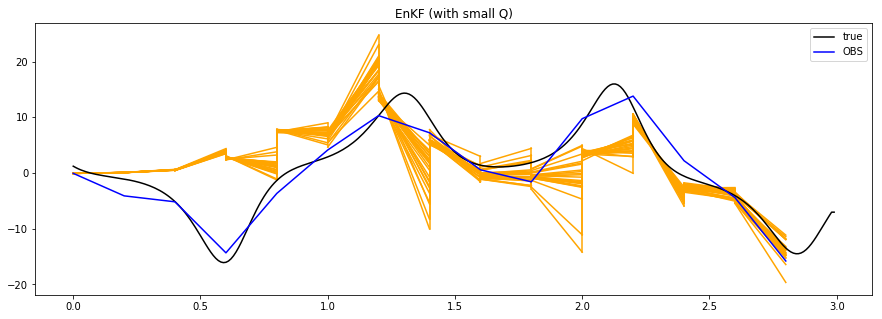

In [91]:

R_new = R#*0.1
Q_new = Q*0.0001

## Generate initial ensemble
N_ens = 23   # number of ensemble members
xtld_hist = np.zeros((3, N_ens, N_obs))  # History of forecasts (x tilde)
xhat_hist = np.zeros((3, N_ens, N_obs))  # History of updated x's (x hat)
muw = np.zeros(3)   # the mean of process noise
mvw = np.zeros(3)   # the mean of sensor noise
Qh0 = Q_new               # initlal Q
w0 = np.random.multivariate_normal(muw, Qh0, size=N_ens).T  # Perturbations for the IC
x0_pure = np.array([[y[0,0], y[1,0], y[2,0]]]).T   # Unperturbed IC
xh0 = x0_pure + w0 # Initial position of ensemble members
xhat_hist[:,:,0] = xh0
xtld_hist[:,:,0] = xh0


## Move through time
for i in range(1,N_obs):
    ## Forecast
    wt = np.random.multivariate_normal(muw, Q_new, size=N_ens).T  # Draw process noise
    prev_update = xhat_hist[:,:,i-1].copy()
    xtld = advance_time(prev_update, coeffs, h_obs) + wt
    xtld_hist[:,:,i] = xtld
    
    ## Update
    Ct = np.cov(xtld)    # Calculate sample covariance
    Kt = Ct @ H.T @ np.linalg.inv(H @ Ct @ H + R_new)  # Calculate Kalman gain
    vt = np.random.multivariate_normal(mvw, R_new, size=N_ens).T  # Draw measurement noise
    ytld = H@xtld - vt    # Calculate simulated observations
    yact = y[:,i][:,np.newaxis]  # Actual observation
    xhat = xtld + Kt @ (yact - ytld)
    xhat_hist[:,:,i] = xhat

## Plot true state; true state + measurement noise; EnKF update predictions
plt.figure(figsize=[15,5])
for ens in range(N_ens):
    for i in range(14):
        
        plt.plot([i*0.2,i*0.2],  [xtld_hist[0,ens,i],xhat_hist[0,ens,i]],color='orange')
        plt.plot([i*0.2,(i+1)*0.2],[xhat_hist[0,ens,i],xtld_hist[0,ens,i+1]],color='orange')
plt.plot(t_sys,x_true[0,:], color='black',label='true')
plt.plot(t_obs,y[0,:], color='blue',label='OBS')
plt.title('EnKF (with small Q)')
plt.legend();plt.show()

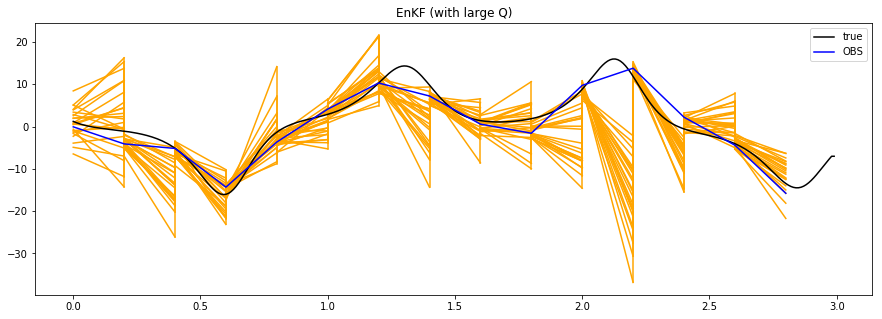

In [92]:

R_new = R#*0.1
Q_new = Q*55#0.001

## Generate initial ensemble
N_ens = 23   # number of ensemble members
xtld_hist = np.zeros((3, N_ens, N_obs))  # History of forecasts (x tilde)
xhat_hist = np.zeros((3, N_ens, N_obs))  # History of updated x's (x hat)
muw = np.zeros(3)   # the mean of process noise
mvw = np.zeros(3)   # the mean of sensor noise
Qh0 = Q_new               # initlal Q
w0 = np.random.multivariate_normal(muw, Qh0, size=N_ens).T  # Perturbations for the IC
x0_pure = np.array([[y[0,0], y[1,0], y[2,0]]]).T   # Unperturbed IC
xh0 = x0_pure + w0 # Initial position of ensemble members
xhat_hist[:,:,0] = xh0
xtld_hist[:,:,0] = xh0


## Move through time
for i in range(1,N_obs):
    ## Forecast
    wt = np.random.multivariate_normal(muw, Q_new, size=N_ens).T  # Draw process noise
    prev_update = xhat_hist[:,:,i-1].copy()
    xtld = advance_time(prev_update, coeffs, h_obs) + wt
    xtld_hist[:,:,i] = xtld
    
    ## Update
    Ct = np.cov(xtld)    # Calculate sample covariance
    Kt = Ct @ H.T @ np.linalg.inv(H @ Ct @ H + R_new)  # Calculate Kalman gain
    vt = np.random.multivariate_normal(mvw, R_new, size=N_ens).T  # Draw measurement noise
    ytld = H@xtld - vt    # Calculate simulated observations
    yact = y[:,i][:,np.newaxis]  # Actual observation
    xhat = xtld + Kt @ (yact - ytld)
    xhat_hist[:,:,i] = xhat

## Plot true state; true state + measurement noise; EnKF update predictions
plt.figure(figsize=[15,5])
for ens in range(N_ens):
    for i in range(14):
        
        plt.plot([i*0.2,i*0.2],  [xtld_hist[0,ens,i],xhat_hist[0,ens,i]],color='orange')
        plt.plot([i*0.2,(i+1)*0.2],[xhat_hist[0,ens,i],xtld_hist[0,ens,i+1]],color='orange')
plt.plot(t_sys,x_true[0,:], color='black',label='true')
plt.plot(t_obs,y[0,:], color='blue',label='OBS')
plt.title('EnKF (with large Q)')
plt.legend();plt.show()